<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

## Check for duplicates

In [3]:
house.duplicated().sum()

0

## Check for rows with a lot of null values

Rule of thumb: Check for rows with less than 70% observations and drop them, as imputation wouldn't make much sense as imputation is aritfically adding information to the observation and this may not be representative of the actual observations

In this case: check for all rows with less than **1020 rows**

It don't make sense to impute either values, we cannot accurately impute either values without knowing additional information based on available data, so this column is dropped, similar information can be found for *Street* column

In [4]:
house.drop('Alley', axis=1, inplace=True)

Based on PoolArea information, we can see that there is only 7 houses with pool, this information will not be a good feature predictor for the actual price, hence both columns are dropped

In [5]:
house.drop(['PoolArea', 'PoolQC'], axis = 1, inplace = True)

It is hard to predict which privacy setting does the house has, in the first place, some houses do not have fence as it is not landed,so this column is dropped too

In [6]:
house.drop('Fence', axis = 1, inplace = True)

Since these miscellaneous features are difficult to predict which category it belongs to, this column is dropped

In [7]:
house.drop('MiscFeature', axis = 1, inplace = True)

Since Fireplaces capture its information that NaN values are house without fireplace, impute NaN to 'None' value instead

In [8]:
house['FireplaceQu'].fillna('NA', inplace = True)

Id of the house is the index, so it can be set as the index

In [9]:
house.set_index('Id', drop=True, inplace = True)

## Remove all the non residential housing

In [10]:
# Non-residential housing has categorical names of A (Agriculture), C (Commerical), I (Industrial)

non_res = ['A', 'C (all)', 'I']

house['MSZoning'] = house['MSZoning'].apply(lambda x: x if x not in non_res else np.nan)

house = house.loc[house['MSZoning'].notnull(), :]

Impute missing value with median since mean and median is close to each, imply higher predictor value

In [11]:
house['LotFrontage'].fillna(house['LotFrontage'].median(), inplace = True)

Since there is only one value of NoSeWa, Electric and Gas only, little information can be extracted from this column, so this column is dropped

In [12]:
house.drop('Utilities', axis = 1, inplace = True)

In [13]:
house['MasVnrType'].fillna('None', axis = 0, inplace = True)

house['MasVnrArea'].fillna(0, axis = 0, inplace = True)

house['BsmtQual'].fillna(house['BsmtQual'].mode()[0], axis = 0, inplace = True)

house['BsmtCond'].fillna(house['BsmtCond'].mode()[0], axis = 0, inplace = True)

house['BsmtExposure'].fillna(house['BsmtExposure'].mode()[0], axis = 0, inplace = True)            

house['BsmtFinType1'].fillna(house['BsmtFinType1'].mode()[0], axis = 0, inplace = True)            

house['BsmtFinType2'].fillna(house['BsmtFinType2'].mode()[0], axis = 0, inplace = True)            

house['BsmtFinSF1'].fillna(house['BsmtFinSF1'].mode(), axis = 0, inplace = True) 

house['BsmtFinSF2'].fillna(house['BsmtFinSF2'].mode(), axis = 0, inplace = True) 

house['Electrical'].fillna(house['Electrical'].mode(), axis = 0, inplace = True)

house['GarageType'].fillna(house['GarageType'].mode().values[0], inplace = True)

house['GarageYrBlt'].fillna(house['GarageYrBlt'].median(), inplace = True)

house['GarageFinish'].fillna(house['GarageFinish'].mode()[0], inplace = True)

house['GarageQual'].fillna(house['GarageQual'].mode()[0], inplace = True)

house['GarageCond'].fillna(house['GarageCond'].mode()[0], inplace = True)

## Feature Engineering: Crossed-Column

In [14]:
house['OverallCondQuality'] = house['OverallQual'] * house['OverallCond']

house.drop(['OverallQual', 'OverallCond'], axis = 1, inplace = True)

In [15]:
house['BuildAge'] = house['YrSold'] - house['YearBuilt']

house.drop('YearBuilt', axis = 1, inplace = True)

In [16]:
house['GarageAge'] = house['YrSold'] - house['GarageYrBlt']

house.drop('GarageYrBlt', axis = 1, inplace = True)

In [17]:
house['RemodAge'] =  house['YrSold'] - house['YearRemodAdd']

house.drop('YearRemodAdd', axis = 1, inplace = True)

house.loc[house['RemodAge'] == -1, 'RemodAge'] = 0

In [18]:
house['Condition'] = np.where(house['Condition1'] == house['Condition2'], house['Condition1'], \
         house['Condition1'] + house['Condition2'])

house.drop(['Condition1', 'Condition2'], axis = 1, inplace = True)

## Categorical Ordering Features

Not all categorical features need to use one-hot encoding, for ordered categorical features, it is better to assign higher weight to 'better' row, for example 'Excellent' has rating of 5, 'Poor' has rating of 1

In [19]:
ExterFx= lambda x: 5 if x == 'Ex' else 4 if x == 'Gd' else 3 if x == 'TA' else 2 if x == 'Fa' else 1

house['Overall'] = (house['ExterQual'].apply(ExterFx) * house['ExterCond'].apply(ExterFx))

house.drop(['ExterQual', 'ExterCond'], axis = 1, inplace = True)

In [20]:
BsmtFx = lambda x: 5 if x == 'Ex' else 4 if x == 'Gd' else 3 if x == 'TA'\
            else 2 if x == 'Fa' else 1 if x == 'Po' else 0
    
house['BsmtQual'] = house['BsmtQual'].apply(BsmtFx)

house['BsmtCond'] = house['BsmtCond'].apply(BsmtFx)

The *LivArea* and *LowQualFinSF* composed of *1stFlrSF* and *2ndSF*, hence there will be multicollinearity between these variable, so *LivArea* and *LowQualFinSF* are combined to give total surface area

In [21]:
BsmtTypeFx = lambda x : 6 if x == 'GLQ' else 5 if x == 'ALQ' else 4 if x == 'BLQ' else \
                    3 if x == 'Rec' else 2 if x == 'LwQ' else 1 if x == 'Unf' else 0

house['BsmtFinSF'] = house['BsmtFinSF1'] + house['BsmtFinSF2']
house['BsmtFinType'] = house['BsmtFinType1'].apply(BsmtTypeFx) + house['BsmtFinType2'].apply(BsmtTypeFx)

house.drop(['BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF'], axis = 1, inplace = True)

In [22]:
house['OverallSF'] = house['LowQualFinSF'] + house['GrLivArea']
house.drop(['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'LowQualFinSF'], axis = 1, inplace = True)

FullBath = np.where(((house['FullBath'] - house['BsmtFullBath']) < 0), house['FullBath'], house['BsmtFullBath'])

HalfBath = np.where(((house['HalfBath'] - house['BsmtHalfBath']) < 0), house['HalfBath'], house['BsmtHalfBath'])

house['Bath'] = FullBath + HalfBath

house.drop(['FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath'], axis = 1, inplace = True)

In [23]:
KitchenFx = lambda x : 5 if x == 'Ex' else 4 if x == 'Gd' else 3 if x == 'TA' else \
            2 if x == 'Fa' else 1

house['KitchenQual'] = house['KitchenQual'].apply(KitchenFx)

In [24]:
FireplaceFx = lambda x : 5 if x == 'Ex' else 4 if x == 'Gd' else 3 if x == 'TA' else \
            2 if x == 'Fa' else 1 if x == 'Po' else 0
    
house['FireplaceQu'] = house['FireplaceQu'].apply(FireplaceFx)

In [25]:
GarageFx = lambda x : 5 if x == 'Ex' else 4 if x == 'Gd' else 3 if x == 'TA' else 2 \
            if x == 'Fa' else 1 if x == 'Po' else 0
house['Garage'] = house['GarageQual'].apply(GarageFx) * house['GarageCond'].apply(GarageFx) * house['GarageArea']

house.drop(['GarageArea', 'GarageCond', 'GarageArea'], axis = 1, inplace = True)

In [26]:
house['PorchArea'] = house['OpenPorchSF'] + house['EnclosedPorch'] + house['3SsnPorch'] + house['ScreenPorch']

house.drop(['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'WoodDeckSF'], axis = 1, inplace = True)

## Features Filter

### Continuous features
1. Pearson Ranking (Correlation)
2. Shapiro Ranking (Test of normality)
3. Variance Inflation Factor (Test of multicollinearity)
4. Eliminate features with low variance

### Categorical features
1. Eliminate features with low variance

## Checking coefficient

In [27]:
continuous_features = house._get_numeric_data()

In [28]:
from yellowbrick.features.rankd import Rank2D, Rank1D

In [29]:
y = continuous_features['SalePrice']
X = continuous_features.drop(['SalePrice', 'YrSold'], axis = 1)

## Pearson Ranking of continuous features

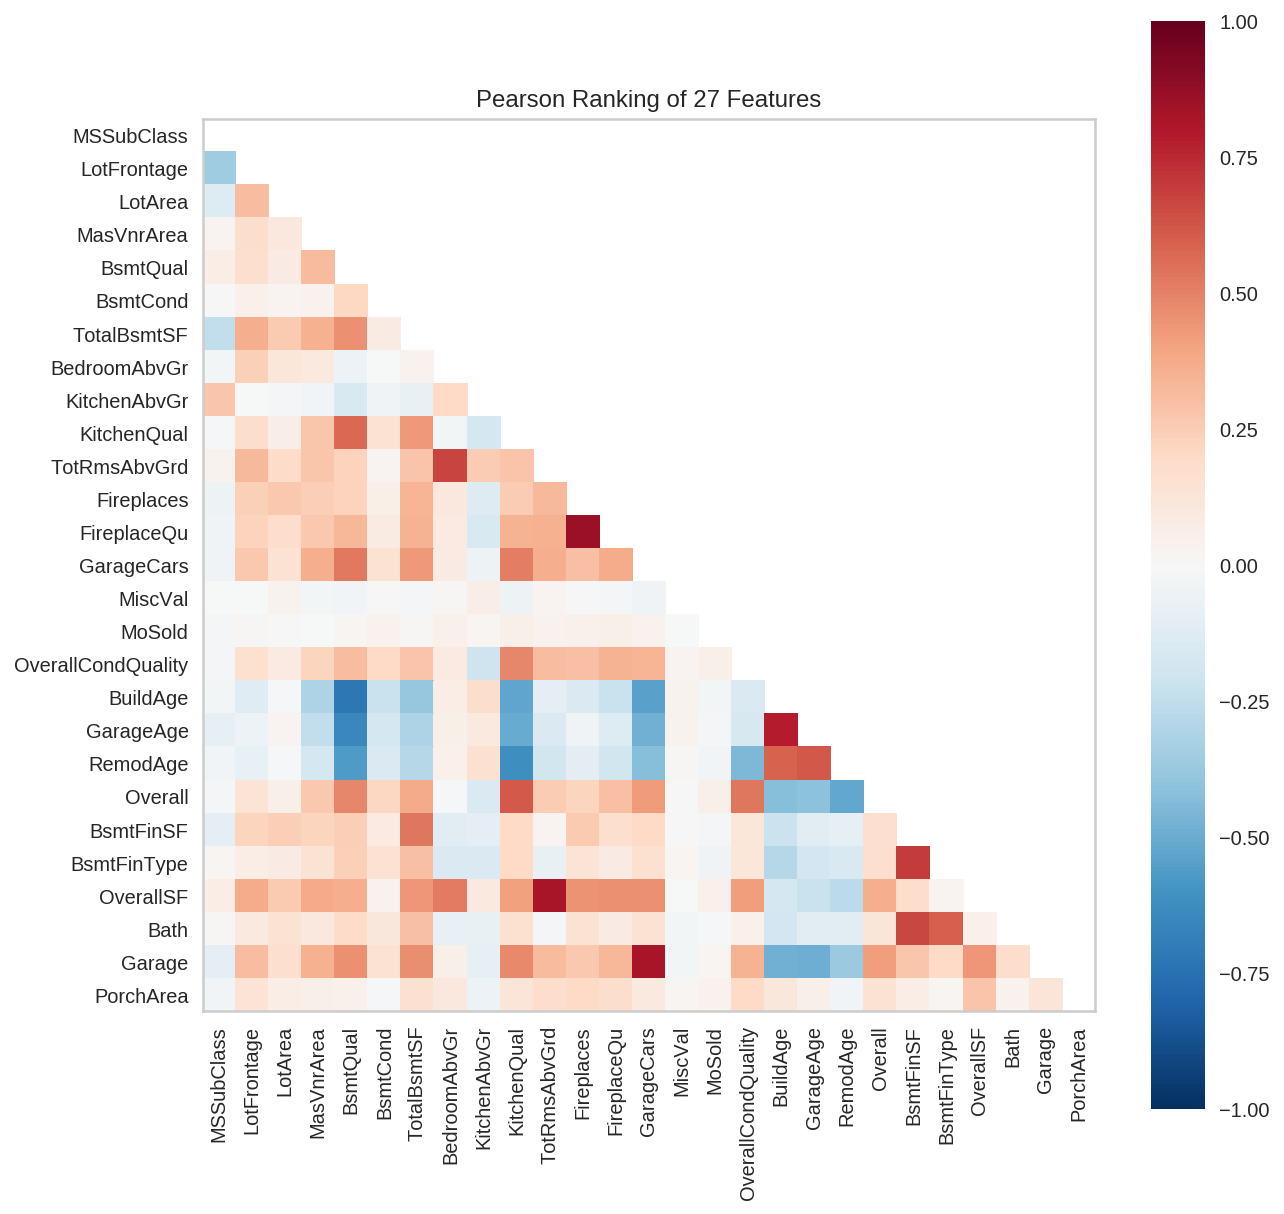

In [30]:
plt.figure(figsize=(10,10))
visualizer = Rank2D()
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.poof()

## Correlation

GarageCars and OverallSF should show high correlation to multiple variable, to avoid multicollinearity, they are dropped

In [31]:
house.drop(['FireplaceQu', 'Garage', 'TotRmsAbvGrd'], axis = 1, inplace = True)

## Shapiro Ranking for normality of features

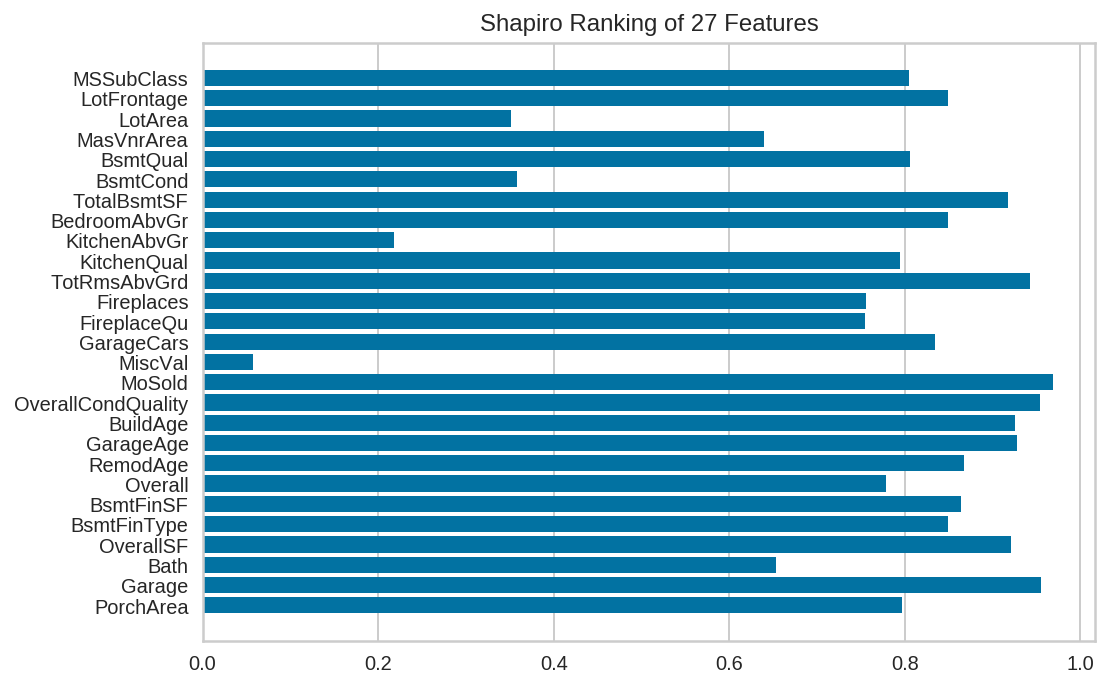

In [32]:
visualizer = Rank1D()
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.poof()

Drop columns with low Shapiro ranking (less than 0.1), it means that the column doesn't follow a normal distribution

In [33]:
house.drop('MiscVal', axis = 1, inplace = True)

## Variance Inflation Factor for continuous columns

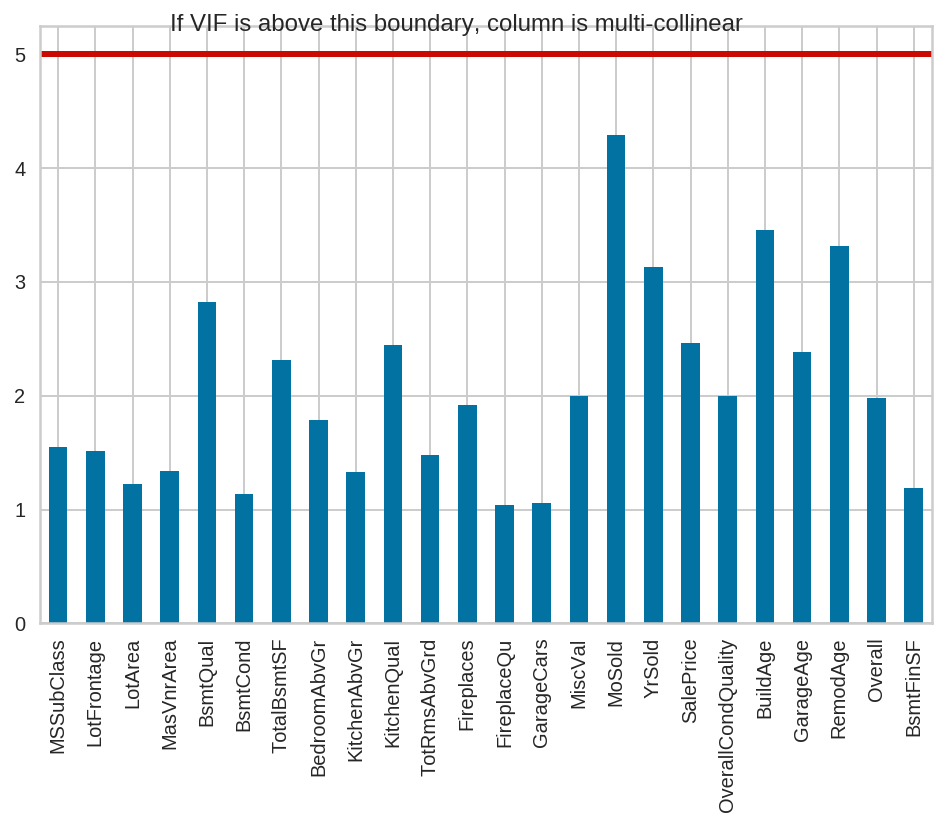

In [34]:
X = house._get_numeric_data()
X.drop('SalePrice', axis = 1, inplace = True)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

from statsmodels.stats.outliers_influence import variance_inflation_factor

VIF = [(continuous_features.columns[i], variance_inflation_factor(X, i)) for i in range(X.shape[1])]

VIF_df = pd.DataFrame(list(zip(*VIF)[1]), index = list(zip(*VIF)[0]))

fig, ax = plt.subplots()
VIF_df.plot(kind = 'bar', legend = False, ax = ax)
ax.axhline(5, c = 'r', lw = 3)
ax.text(3, 5.2, 'If VIF is above this boundary, column is multi-collinear')

VIF explains if there is multicollinearity in the data, it is a common practice to drop columns with VIF values greater than 5, no column is dropped

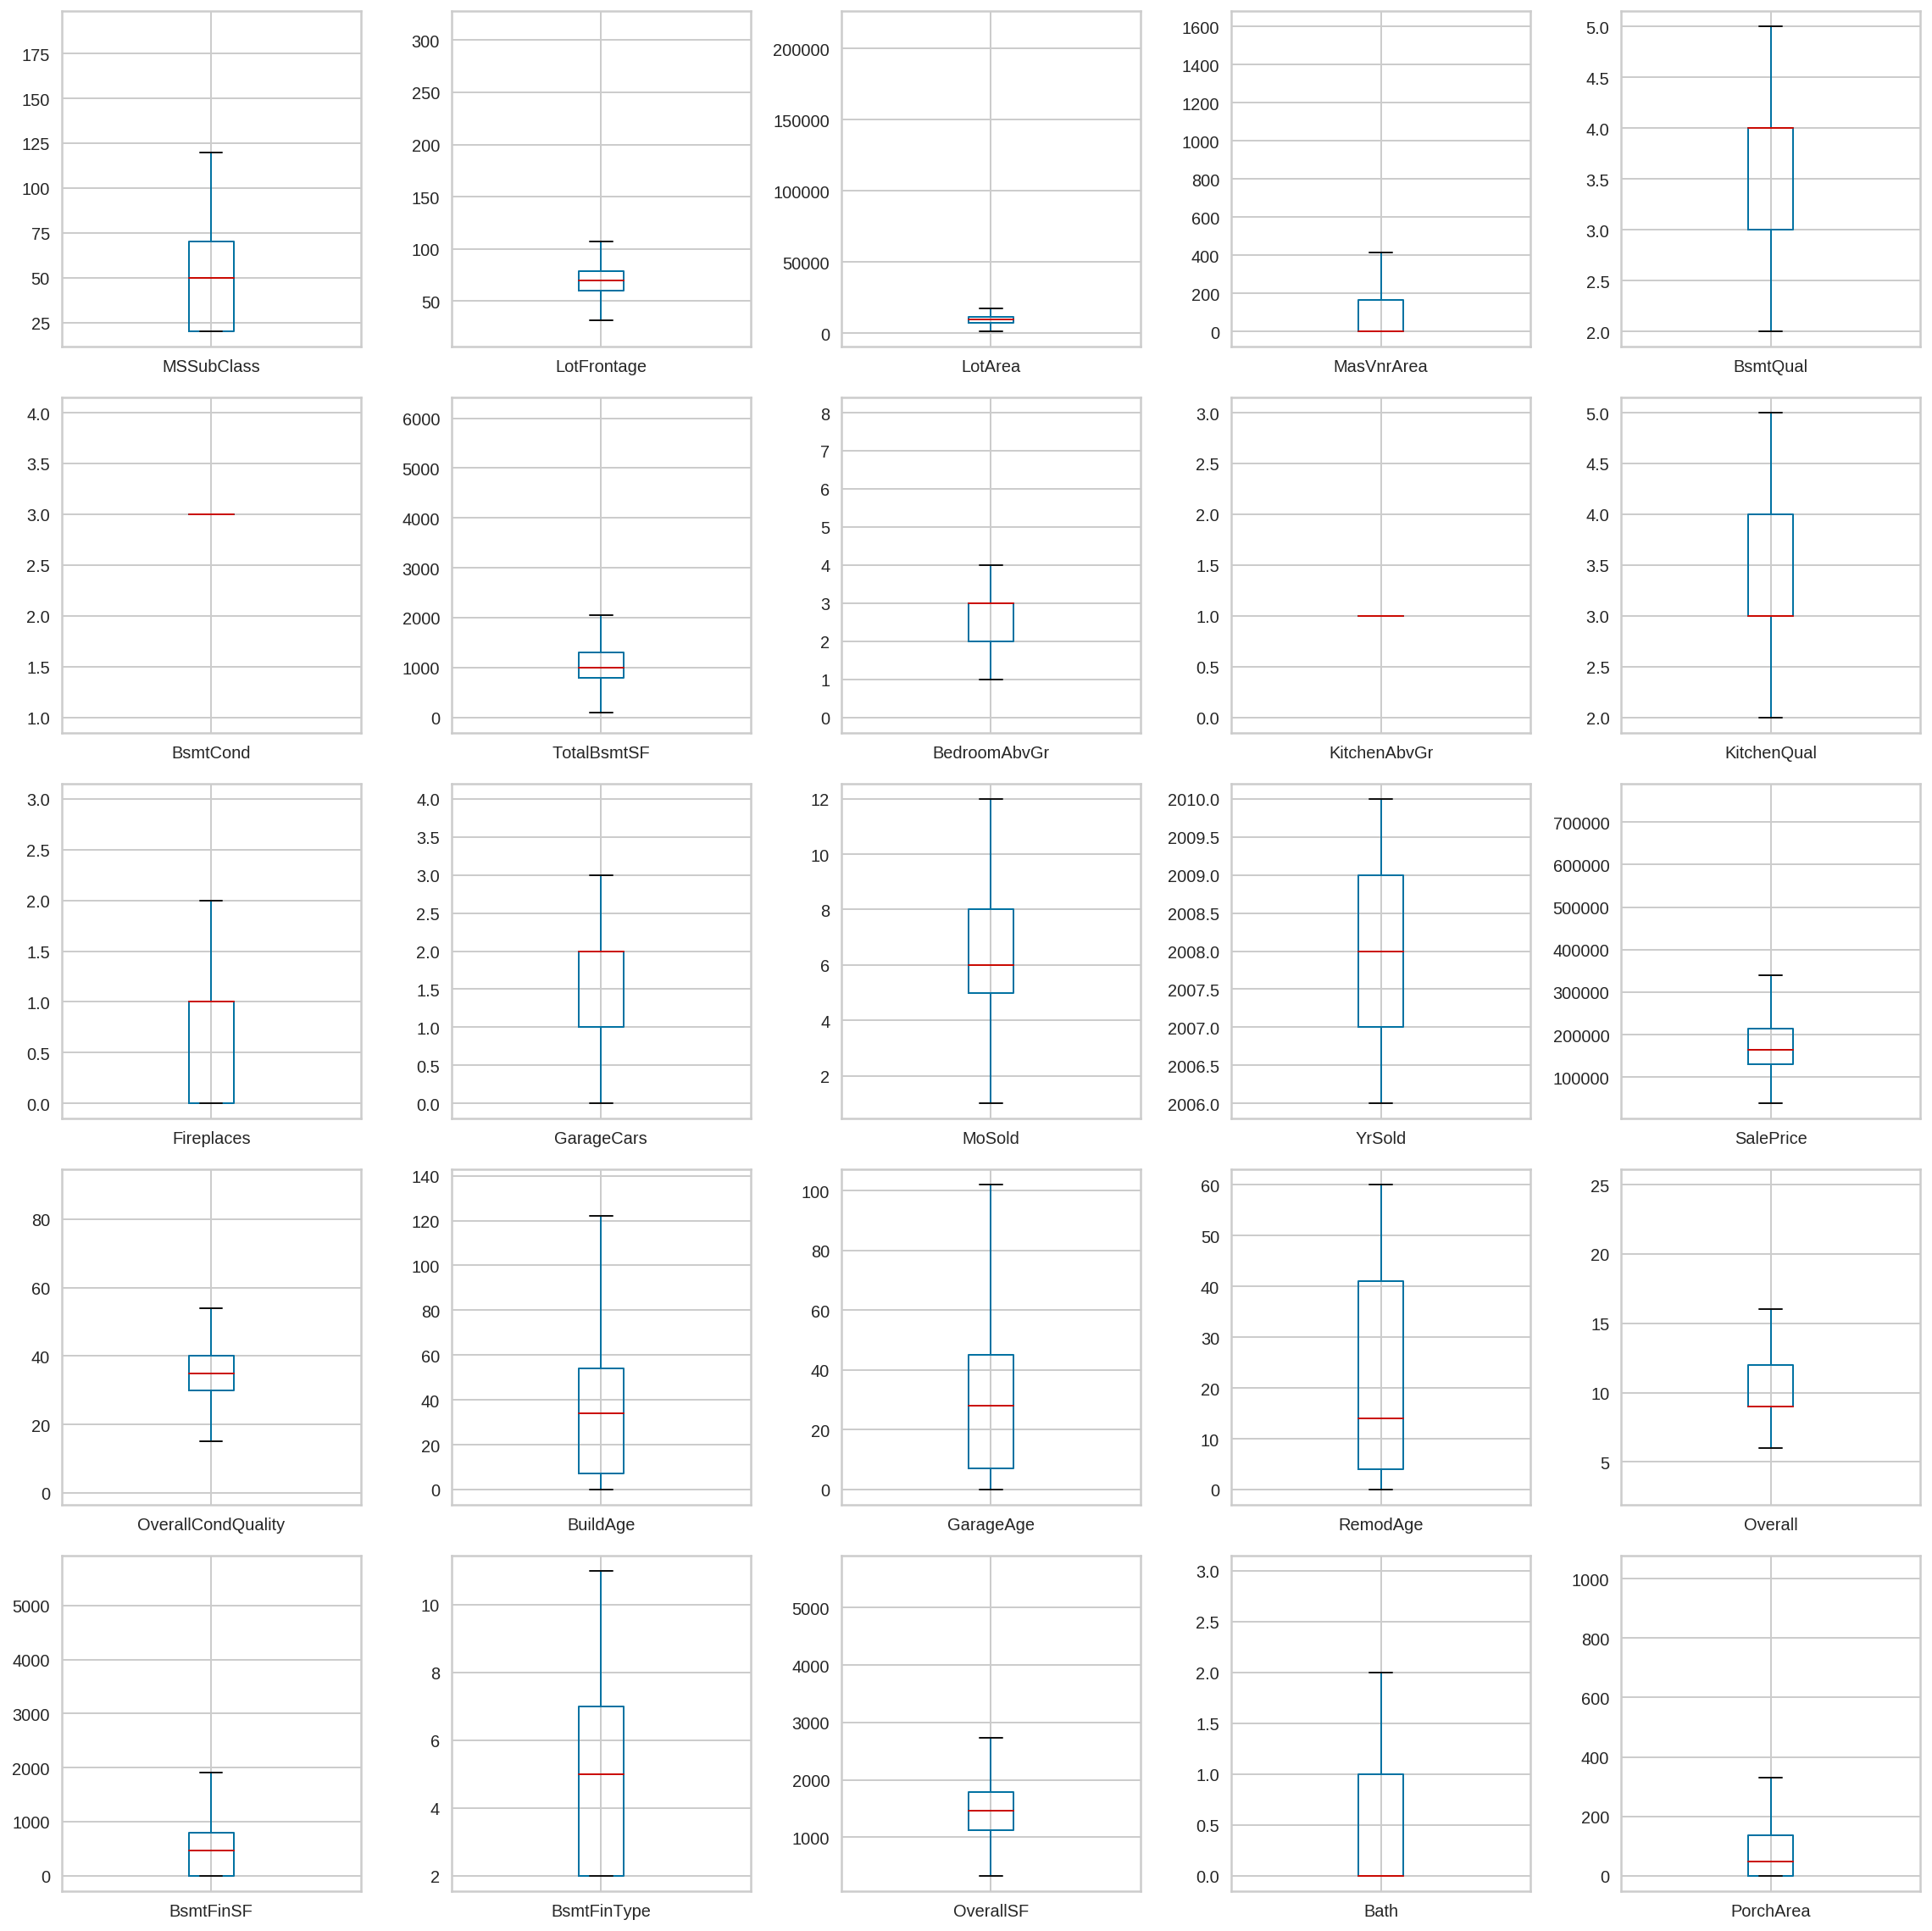

In [35]:
continuous_features = house._get_numeric_data()

fig, ax = plt.subplots(nrows =  5, ncols= 5, figsize = (16, 16))
for idx, col_name in enumerate(continuous_features.columns):
    row = int(idx / 5)
    col = int(idx % 5)
    continuous_features[[col_name]].boxplot(ax= ax[row][col])
plt.tight_layout()
fig.patch.set_facecolor('white')

In [36]:
col_to_drop = ['Street', 'LandSlope', 'LandContour', 'RoofMatl', 'Heating', \
               'CentralAir', 'Electrical', 'Functional' , 'PavedDrive']

house.drop(col_to_drop, axis = 1, inplace = True)

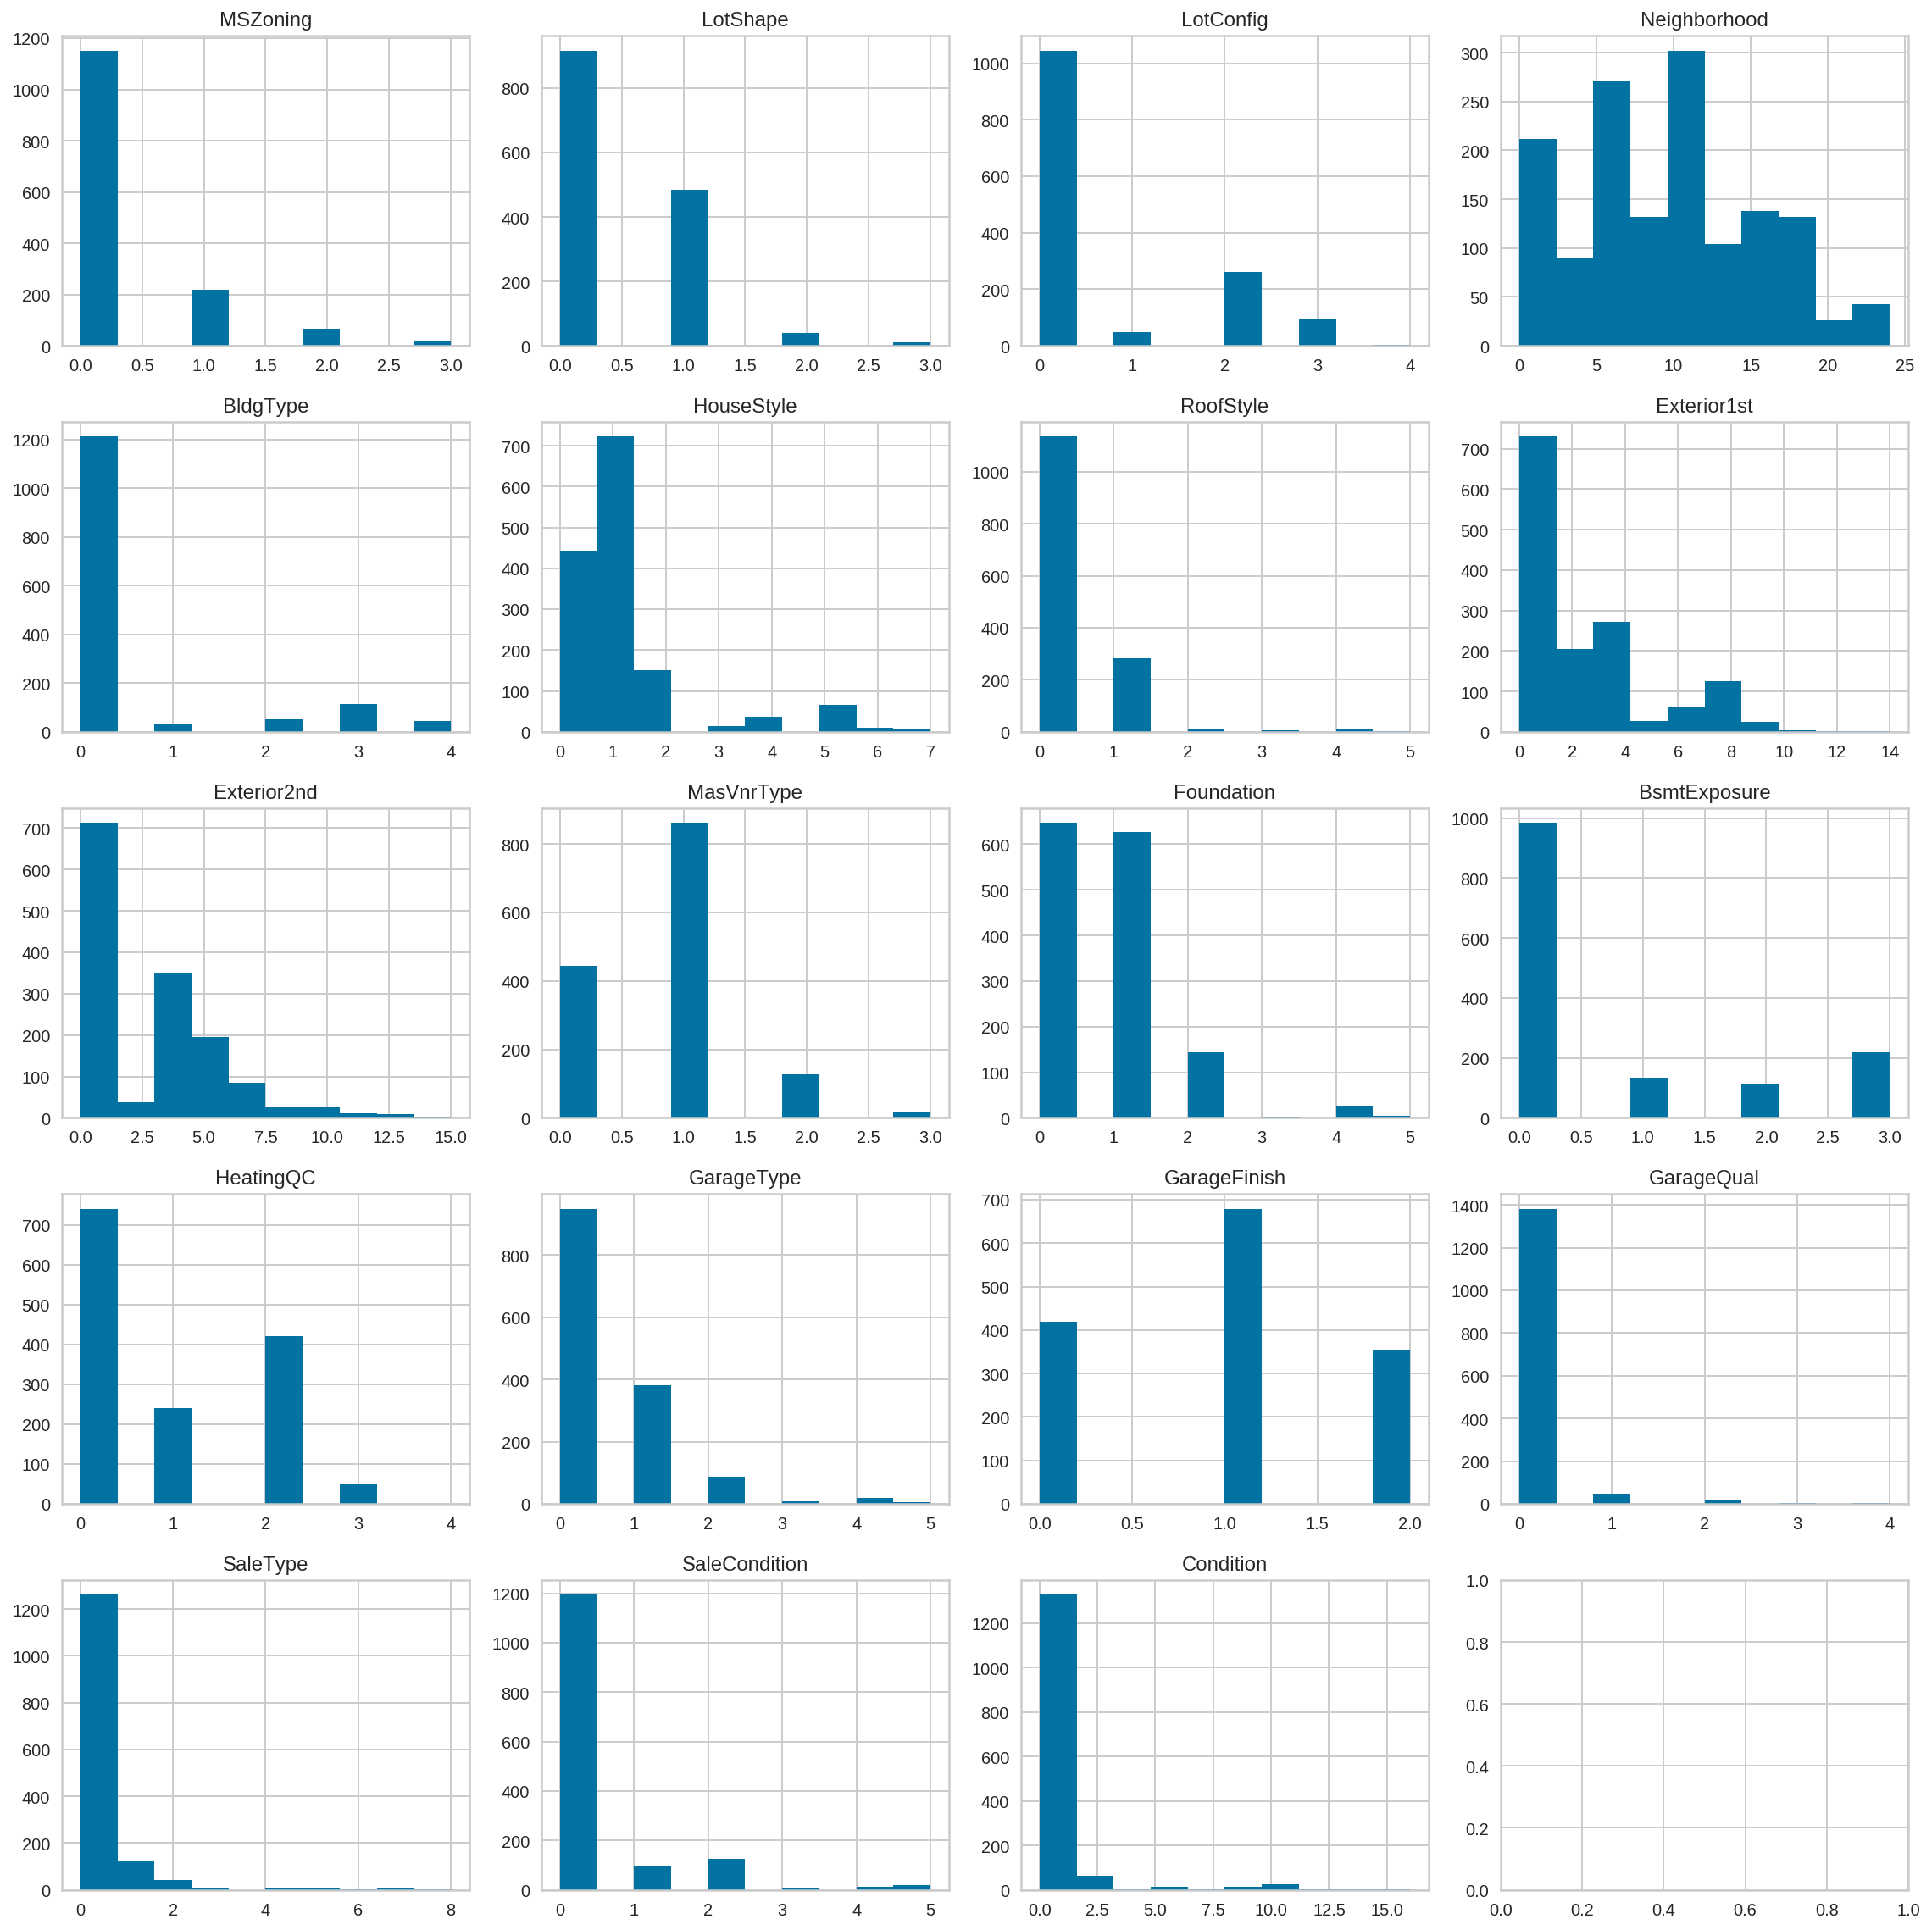

In [37]:
categorical_features = house.loc[:, ~house.columns.isin(house._get_numeric_data().columns)]

fig, ax = plt.subplots(nrows=5, ncols = 4, figsize = (16,16))

for idx, col_name in enumerate(categorical_features.columns):
    row = int(idx / 4)
    col = int(idx % 4)
    ax[row][col].set_title(col_name)
    ax[row][col].hist(house[col_name].factorize()[0])

plt.tight_layout()

fig.patch.set_facecolor('white')

There are columns that is very skewed, these columns contain little information (more than 90% in a particular category) to predict the target variables, in this case, they are dropped.

Similarly, continuous column with little variance is dropped

In [38]:
house.drop(['BsmtCond', 'KitchenAbvGr'], axis = 1, inplace = True)

## Binary Encoding

Instead of ordinal coding, binary encoding is proposed such that each binary value is split into column

Ranking | Binary
---------|--------
1 | [0,0,1]
2 | [0,1,0]
3 | [0,1,1]
4 | [1,0,0]

In [39]:
from category_encoders.binary import BinaryEncoder
bin_encoder = BinaryEncoder()

housebin = pd.concat([house, bin_encoder.binary(house[['Overall']])], axis = 1)

housebin = pd.concat([housebin, bin_encoder.binary(house[['BsmtQual']])], axis = 1)

housebin = pd.concat([housebin, bin_encoder.binary(house[['BsmtFinType']])], axis = 1)

housebin = pd.concat([housebin, bin_encoder.binary(house[['KitchenQual']])], axis = 1)

housebin.drop(['Overall', 'BsmtQual','BsmtFinType', 'KitchenQual', 'SalePrice', 'YrSold'], axis = 1, inplace = True)

## Remove all the non-fixed features

In [40]:
non_fixed = ['Exterior1st', 'Exterior2nd', 'MasVnrType', 'HeatingQC', 'GarageFinish', \
             'Bath']

YrSold = house['YrSold']
y = house['SalePrice']

house.drop(['SalePrice', 'YrSold'], axis = 1, inplace = True)

Z = housebin.drop(non_fixed, axis = 1)

### Create a sklearn class to one-hot encode the categorical columns, standard scale the continuous columns and append them together

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin

class ScaleEncoder (BaseEstimator, TransformerMixin):
    """
    scale_encoder
    This class is to perform one-hot encoding on the categorical feature and standard scale the continuous features.
    It will then return the appended one-hot columns and continous columns as a numpy array to be used in a pipeline.
    """
    def __init__ (self):
        pass
    
    def fit (self, X):
        """
        fit
        
        args:
            self
            X (DataFrame) containing categorical and continuous features 
        return:
            self
        """
        return self
        
    def transform (self, X):
        """
        transform
        
        args:
            self
            X (DataFrame) containing categorical and continuous features
        return:
            appended numpy array with appended one-hot categorical features and standard scaled continuous features
        """
        # Get all the continuous features and standard scale it
        continous_features = X._get_numeric_data()
        continous_columns = X._get_numeric_data().columns
        scaler = StandardScaler()
        continous_features = scaler.fit_transform(continous_features)
    
        # Get all the categorical features and perform get dummies, dropping its first column to avoid collinearity
        categorical_columns = X.loc[: , ~ X.columns.isin(continous_columns)].columns
        categorical_features = pd.get_dummies(X.loc[:, categorical_columns], drop_first = True)

        # Append and return the continous features with the categorical features 
        return np.hstack([continous_features, categorical_features.values])


In [42]:
scale_encoder = ScaleEncoder()
X = scale_encoder.fit_transform(Z)

## Split data into pre-2010 and 2010 data

In [43]:
train_index = YrSold < 2010 
test_index = YrSold == 2010

X_train, y_train = X[train_index], y[train_index]
X_test, y_test = X[test_index], y[test_index]

In [44]:
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV, ElasticNetCV, SGDRegressor, Ridge, Lasso

from sklearn.model_selection import cross_val_score

svr_cv = cross_val_score(SVR(kernel = 'linear'), X_train, y_train, cv = 5, n_jobs = -1)
print ('SVR cross validation score is {}'.format(np.mean(svr_cv)))

linear_cv = cross_val_score(LinearRegression(n_jobs = -1), X, y, n_jobs = -1, cv = 5)
print ('Linear Regression cross validation score is {}'.format(np.mean(linear_cv)))

ridgecv_cv = cross_val_score(RidgeCV(cv = 3), X, y, n_jobs = -1, cv = 5)
print ('Ridge Regression cross validation score is {}'.format(np.mean(ridgecv_cv)))

lassocv_cv = cross_val_score(LassoCV(n_jobs = -1), X, y, n_jobs = -1, cv = 5)
print ('Lasso Regression cross validation score is {}'.format(np.mean(lassocv_cv)))

elastic_cv = cross_val_score(ElasticNetCV(n_jobs = -1), X, y, n_jobs = -1, cv = 5)
print ('Elastic Regression cross validation score is {}'.format(np.mean(elastic_cv)))

SVR cross validation score is 0.0515197754609
Linear Regression cross validation score is -5.32332241863e+13
Ridge Regression cross validation score is 0.823619886551
Lasso Regression cross validation score is 0.82437047558
Elastic Regression cross validation score is 0.13689408335


### Model Selection

Model | R2 Cross Validation Score
-------|---------------
SVR | 0.0515
Linear Regression | -3.879
Ridge CV | 0.823
Lasso CV | 0.824
Elastic | 0.136

Since Ridge Regression has the highest R2 score, Ridge Regression is chosen as the model

## Feature Selection

X has a sparse matrix as it has a lot of categorical features. To reduce its dimensionality, I proposed using three methods to reduce its dimension

1. Recursive Feature Elimination
2. Principal Component Analysis
3. Lasso Coefficient
4. Lasso: Least Angle Regression - AIC Criterion

## Recursive Feature Elimination Cross-Validation

Recursive feature elimination using Ridge

Ridge is chosen as the L2 regularization enforce a stricter penalty

In [45]:
from sklearn.feature_selection import RFECV

rfe = RFECV(RidgeCV(), cv = 3, n_jobs = -1)
rfe.fit(X_train, y_train)
X_train_rfe = X_train[:, rfe.support_]
X_test_rfe = X_test[:, rfe.support_]

ridge_rfe_cv = cross_val_score(RidgeCV(), X_train_rfe, y_train, cv = 5, scoring = 'r2')

## Principal Component Analysis

To reduce the dimensions of the features to 95% variance

In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.95)
X_train_PCA = pca.fit_transform(X_train)

lasso_pca_cv = cross_val_score(RidgeCV(), X_train_PCA, y_train, cv = 5, scoring = 'r2')

## Lasso

Check which lasso coefficient is close to zero and eliminate it

In [47]:
lasso = LassoCV(n_jobs = -1)
lasso.fit(X_train, y_train)

X_train_lasso = X_train[:, lasso.coef_ != 0]

lasso_cv = cross_val_score(LassoCV(), X_train_lasso, y_train, cv = 5, scoring = 'r2')

<Container object of 124 artists>

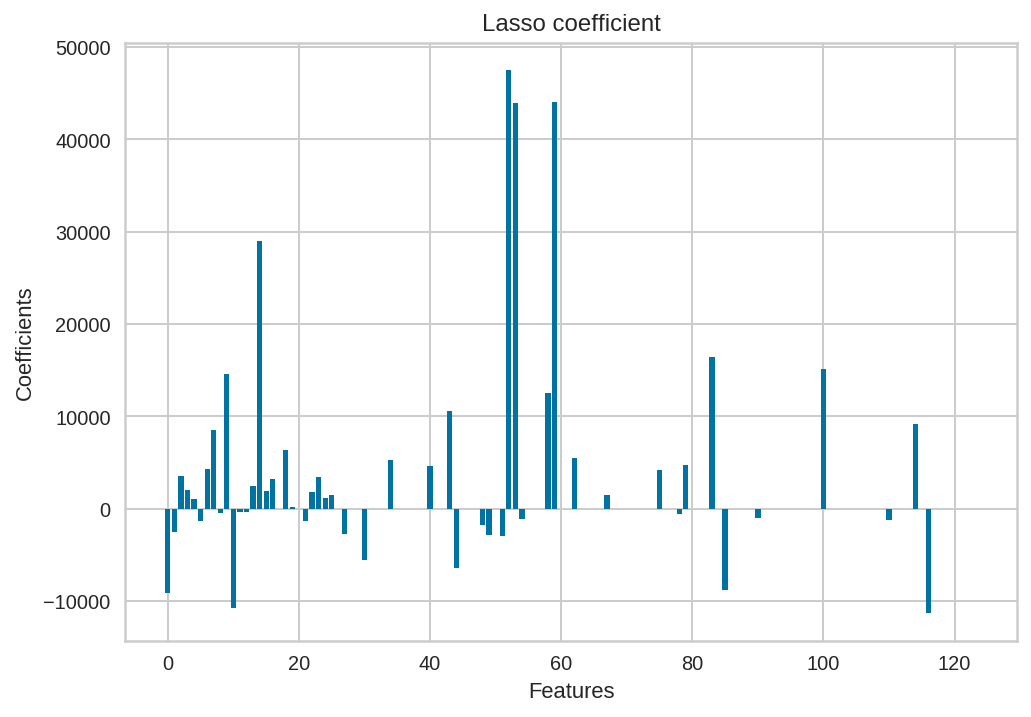

In [48]:
plt.title('Lasso coefficient')
plt.ylabel('Coefficients')
plt.xlabel('Features')
plt.bar(np.arange(len(lasso.coef_)), lasso.coef_)

## LARS Lasso AIC

In [49]:
from sklearn.linear_model import LassoLarsIC

lars = LassoLarsIC()
lars.fit(X_train, y_train)

X_train_lars = X_train[:, lars.coef_ != 0]

lars_cv = cross_val_score(RidgeCV(), X_train_lars, y_train, cv = 5, scoring = 'r2')

<Container object of 124 artists>

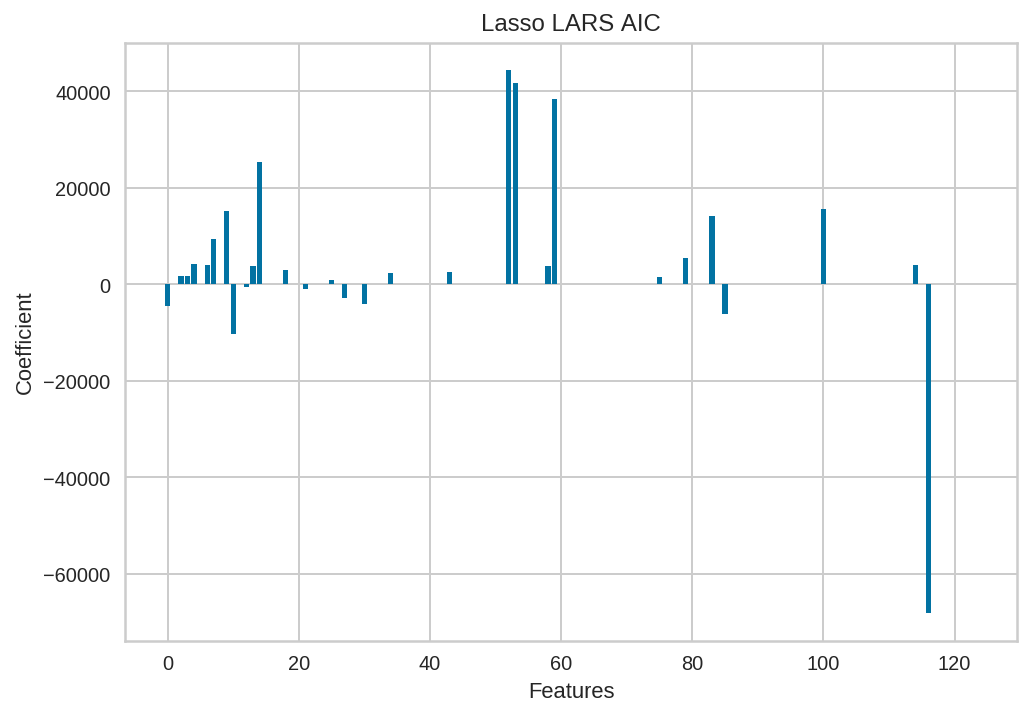

In [50]:
plt.title('Lasso LARS AIC')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.bar(np.arange(len(lars.coef_)), lars.coef_)

## No Scaling

In [51]:
no_scale_cv = cross_val_score(RidgeCV(), X_train, y_train, cv = 5, scoring = 'r2')

In [52]:
print ('RFE cross validation score is {}'.format(np.mean(ridge_rfe_cv)))
print ('PCA cross validation score is {}'.format(np.mean(lasso_pca_cv)))
print ('Lasso cross validation score is {}'.format(np.mean(lasso_cv)))
print ('LARS cross validation score is {}'.format(np.mean(lars_cv)))
print ('Ridge for no scaling cross validation score is {}'.format(np.mean(no_scale_cv)))

RFE cross validation score is 0.832415856242
PCA cross validation score is 0.788589049116
Lasso cross validation score is 0.817012286447
LARS cross validation score is 0.824829858098
Ridge for no scaling cross validation score is 0.814808559124


## Wrapper Feature Selection

Wrapper Function | R2 Score
--------------------|-----------
RFE | 0.832
95% Variance PCA | 0.789
Lasso | 0.818
LARS AIC Criterion | 0.815
No wrapper | 0.815

Since RFE can select best features, RFE selected coefficients are chosen

## Hyperparameter tuning

Using Ridge model and train it on columns that RFE has selected

In [53]:
ridge_cv = RidgeCV(cv = 5, alphas = np.linspace(5, 10, 100))
ridge_cv.fit(X_train_rfe, y_train)

ridge = Ridge(alpha=ridge_cv.alpha_)
ridge.fit(X_train_rfe, y_train)

y_pred_train = ridge.predict(X_train_rfe)
y_pred_test = ridge.predict(X_test_rfe)

print ('R2 for Ridge Regression with RFE selected features is {}'.format(ridge.score(X_test_rfe, y_test)))

R2 for Ridge Regression with RFE selected features is 0.877350469504


In [54]:
from sklearn.metrics import mean_squared_error

print ('The MSE price is {}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))

The MSE price is 27923.6819753


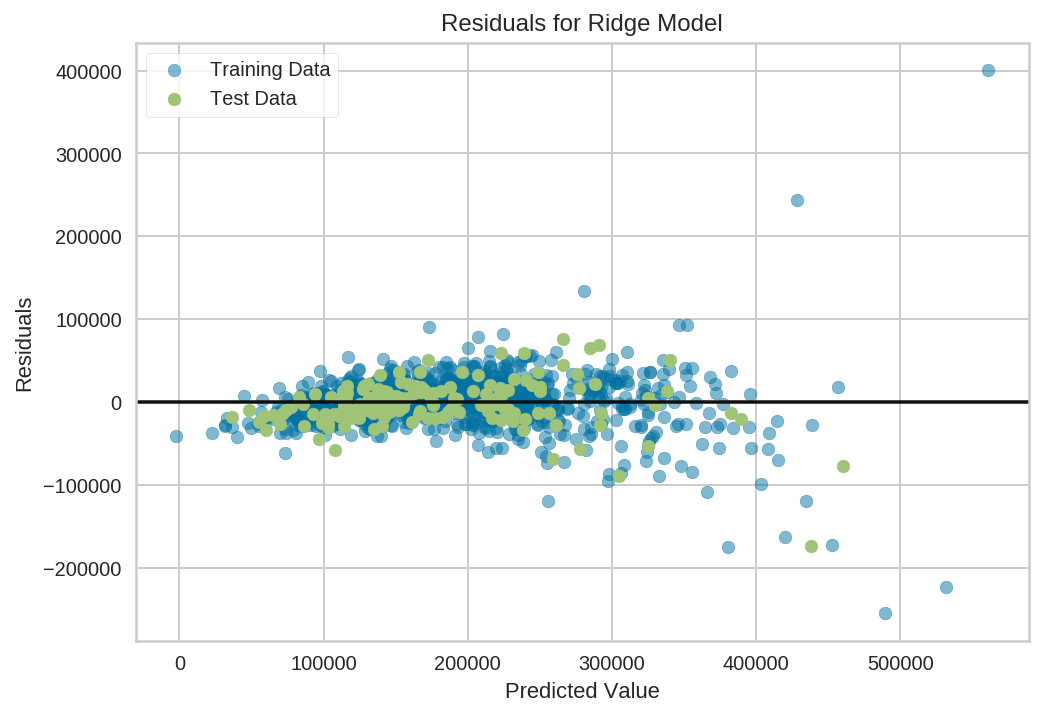

In [55]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(Ridge(alpha = 2.8684210526315788))

visualizer.fit(X_train_rfe, y_train)
visualizer.score(X_test_rfe, y_test)
visualizer.poof()

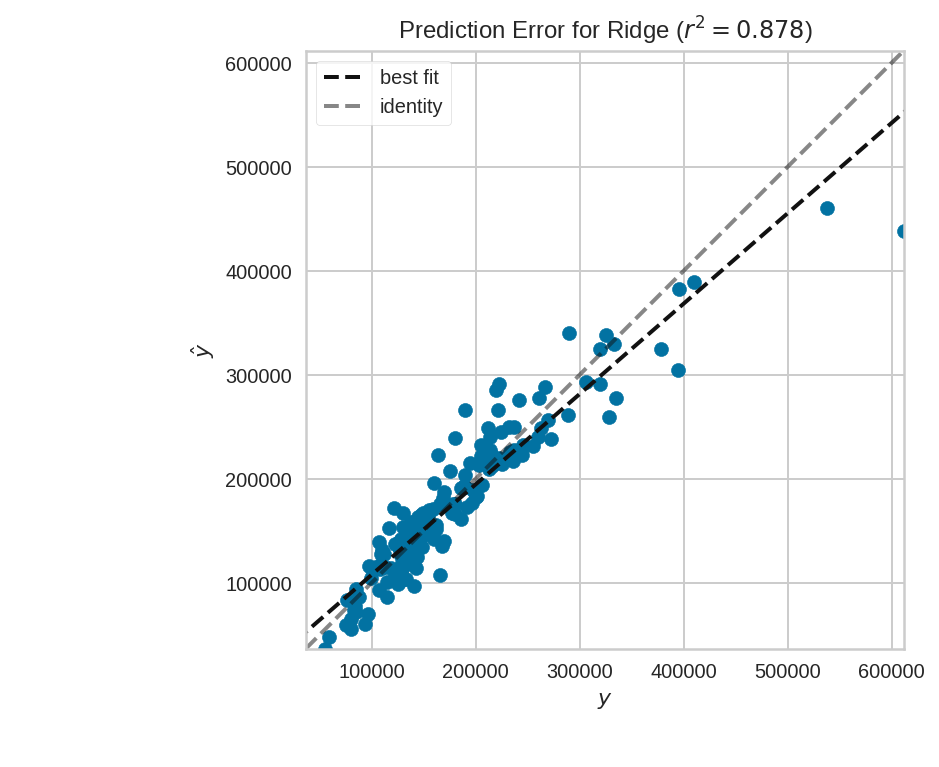

In [56]:
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(Ridge(alpha = 2.8684210526315788))

visualizer.fit(X_train_rfe, y_train)  
visualizer.score(X_test_rfe, y_test)  
visualizer.poof()

In [57]:
import yellowbrick

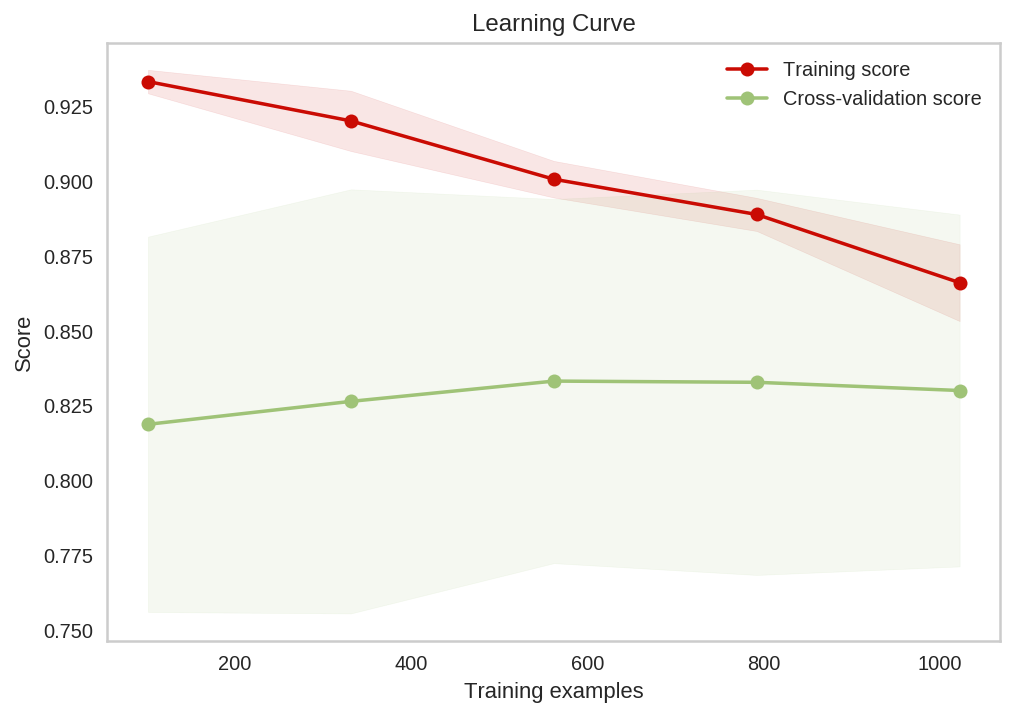

In [58]:
from sklearn.model_selection import learning_curve

plt.title('Learning Curve')

plt.xlabel("Training examples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores = learning_curve(Ridge(alpha = 2.8684210526315788), X = X_train_rfe, 
                                                        y = y_train, cv = 5, n_jobs = -1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\
                     train_scores_mean + train_scores_std, alpha=0.1,\
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",\
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",\
             label="Cross-validation score")

plt.legend(loc="best")

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [59]:
price_diff_train = y_train - y_pred_train

price_diff_test = y_test - y_pred_test

In [60]:
scale_encode = ScaleEncoder()
Z = scale_encode.fit_transform(house.loc[:, non_fixed])

Z_train, Z_test = Z[train_index], Z[test_index]

p_train, p_test = price_diff_train[train_index], price_diff_test[test_index]

## RFE Features Selection

In [61]:
rfe = RFECV(RidgeCV(), cv = 3, n_jobs = -1)
rfe.fit(Z_train, p_train)
Z_train_rfe = Z_train[:, rfe.support_]
Z_test_rfe = Z_test[:, rfe.support_]

print ('RFE CV for Ridge is {}'.format(np.mean(cross_val_score(RidgeCV(), Z_train, p_train, cv = 5, scoring = 'r2', n_jobs = -1))))

RFE CV for Ridge is -0.00591065532403


In [62]:
ridge_cv = RidgeCV(alphas = np.linspace(2.7, 2.9, 20), cv = 5, scoring = 'r2')
ridge_cv.fit(Z_train_rfe, p_train)
p_pred = ridge_cv.predict(Z_test_rfe)

print ('The R2 score is {}'.format(ridge_cv.score(Z_test_rfe, p_test)))
print ('The MSE price is {}'.format(np.sqrt(mean_squared_error(p_test, p_pred))))

The R2 score is 0.00969482782534
The MSE price is 27637.620698


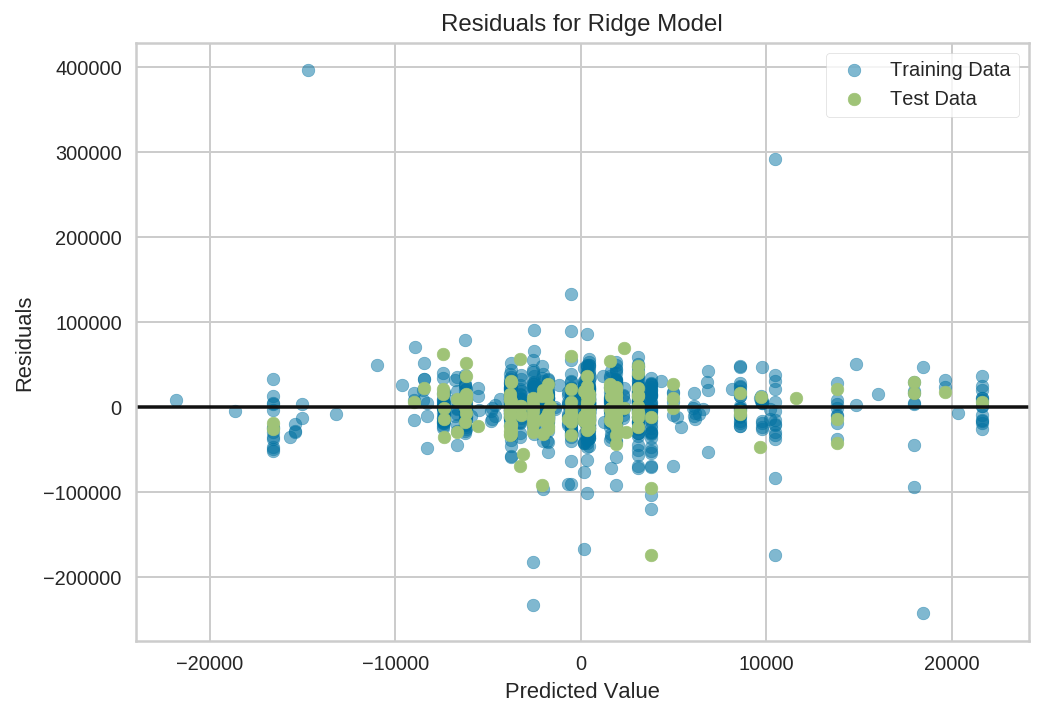

In [63]:
visualizer = ResidualsPlot(Ridge(alpha = 2.8684210526315788))

visualizer.fit(Z_train_rfe, p_train)
visualizer.score(Z_test_rfe, p_test)
visualizer.poof()

## Does it make sense to look at residual as the target variable?

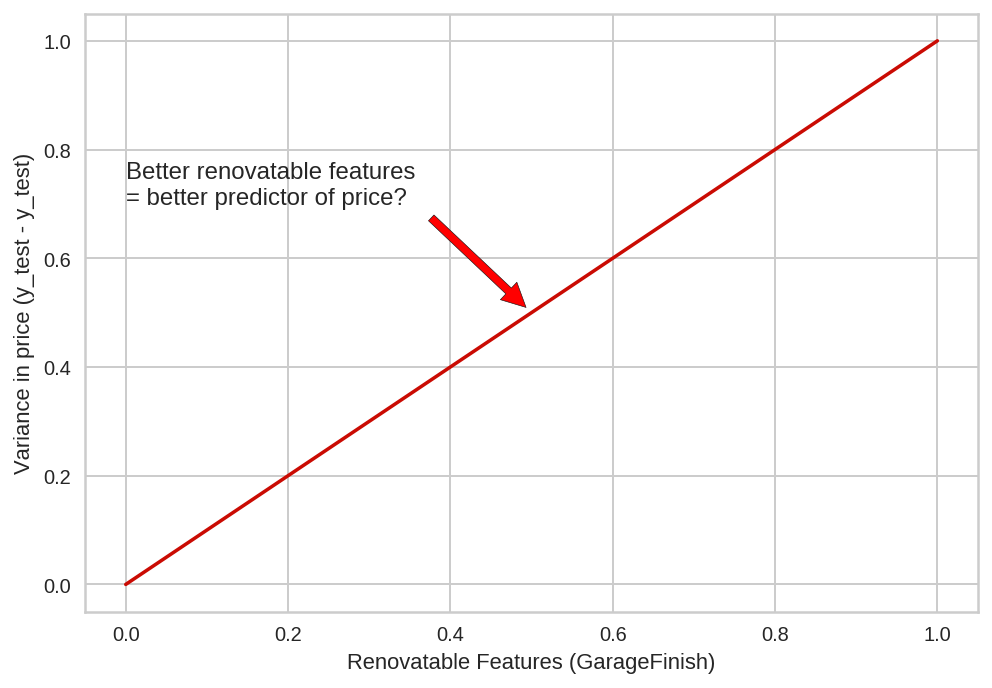

In [64]:
#plt.xkcd()
plt.plot([0, 1], [0, 1], 'r-')
plt.ylabel('Variance in price (y_test - y_test)')
plt.xlabel('Renovatable Features (GarageFinish)')
plt.annotate('Better renovatable features \n= better predictor of price?' , xy = (0.5, 0.5), xytext = (0, 0.7), \
            arrowprops=dict(facecolor='red', shrink=0.05))

## Look at all the features of house

Compare prices from 2 models
1. Both renovatable and fixed features
2. Only fixed features

Take the price and do a t-test to see if renovatable feature has an effect on the pricing of the house

In [65]:
scaler = ScaleEncoder()
W = scaler.fit_transform(house)
W_train, W_test = W[train_index], W[test_index]

ridge_all = RidgeCV()
ridge_all.fit(W_train, y_train)
ridge_all_pred = ridge_all.predict(W_test)

ridge_fixed = RidgeCV()
ridge_fixed.fit(X_train, y_train)
ridge_fixed_pred = ridge_fixed.predict(X_test)

1. Define null hypothesis: Non-fixed features has no effect on the sale price
2. Alpha is 0.05
3. Point Estimate: Sale Price
4. Compute p-value: 0.079
5. Since p-value is larger than alpha, do not reject hypothesis

In [66]:
from scipy import stats

print ('p-value is {}'.format(stats.ttest_ind(ridge_all_pred, ridge_fixed_pred)[0]))

p-value is 0.0797402881179


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [67]:
C = house['SaleCondition']
house.drop('SaleCondition', axis = 1, inplace = True)

In [68]:
D = C.apply(lambda x: 1 if x == 'Abnorml' else 0)

scale_encode = ScaleEncoder()
B= scale_encode.fit_transform(house)
B = np.hstack([B, YrSold.values.reshape(-1, 1)])

## Oversampling the imbalanced group

Only oversample the training group so that the both classes are balanced, leaving the test group imbalance

In [69]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

def plot_resampling(ax, X, y, title):
    c0 = ax.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5)
    c1 = ax.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5)
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([-6, 8])
    ax.set_ylim([-6, 6])

    return c0, c1

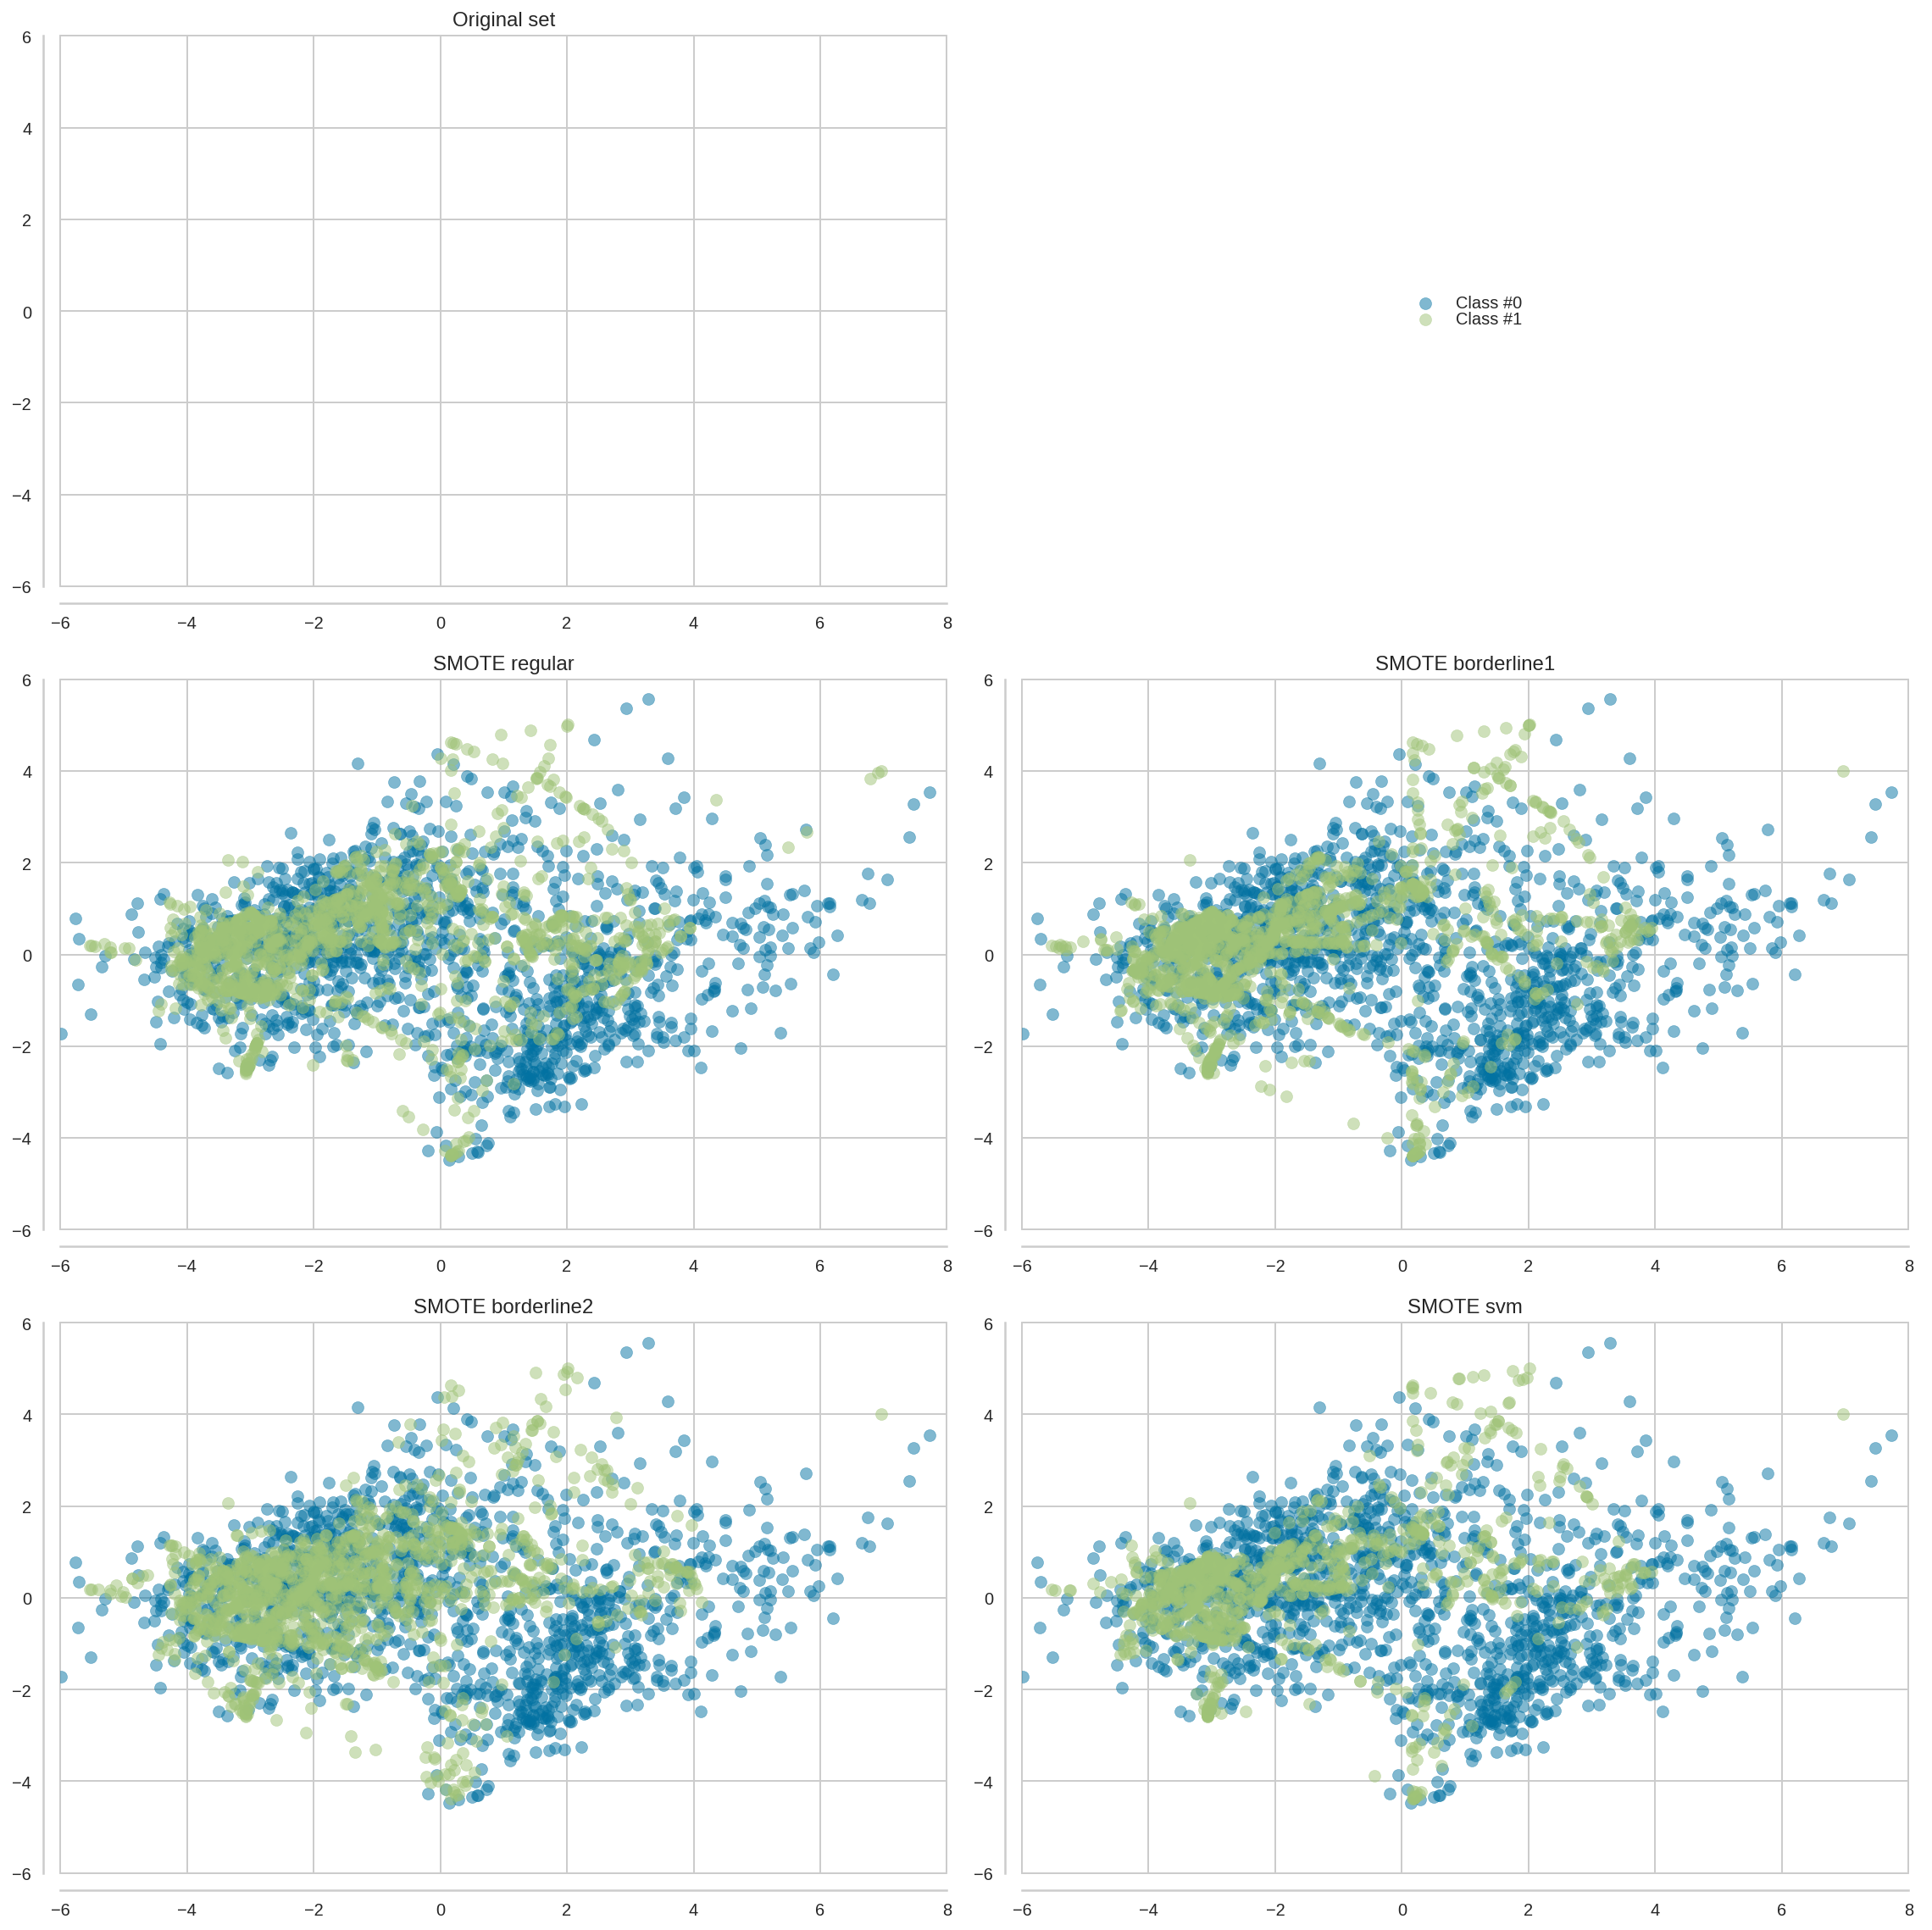

In [70]:
# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components=2)
# Fit and transform x to visualise inside a 2D feature space
X_vis = pca.fit_transform(B)

kind = ['regular', 'borderline1', 'borderline2', 'svm']
sm = [SMOTE(kind=k) for k in kind]
X_resampled = []
y_resampled = []
X_res_vis = []
for method in sm:
    X_res, y_res = method.fit_sample(B, D)
    X_resampled.append(X_res)
    y_resampled.append(y_res)
    X_res_vis.append(pca.transform(X_res))

# Two subplots, unpack the axes array immediately
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize = (16, 16))
# Remove axis for second plot
ax2.axis('off')
ax_res = [ax3, ax4, ax5, ax6]

c0, c1 = plot_resampling(ax1, X_vis, y, 'Original set')
for i in range(len(kind)):
    plot_resampling(ax_res[i], X_res_vis[i], y_resampled[i],
                    'SMOTE {}'.format(kind[i]))

ax2.legend((c0, c1), ('Class #0', 'Class #1'), loc='center',
           ncol=1, labelspacing=0.)
plt.tight_layout()
plt.show()

In [72]:
X_train, X_test = B[train_index], B[test_index]
y_train, y_test = D[train_index], D[test_index]

X_sam, y_sam = SMOTE().fit_sample(X_train, y_train)

print ('The size of both groups is {}'.format(np.unique(y_sam, return_counts = True)[1]))

The size of both groups is [1191 1191]


In [75]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [76]:
logregl1 = cross_val_score(LogisticRegressionCV(penalty = 'l1', solver = 'liblinear'), \
                         X_sam, y_sam, scoring = 'f1',\
                         cv = 5, n_jobs= -1)

svc = cross_val_score(SVC(), \
                         X_sam, y_sam, scoring = 'f1',\
                         cv = 5, n_jobs= -1)

nbc = cross_val_score(GaussianNB(), \
                         X_sam, y_sam, scoring = 'f1',\
                         cv = 5, n_jobs= -1)

dt = cross_val_score(DecisionTreeClassifier(), \
                         X_sam, y_sam, scoring = 'f1',\
                         cv = 5, n_jobs= -1)

rf = cross_val_score(RandomForestClassifier(), \
                    X_sam, y_sam, scoring = 'f1', \
                    cv = 5, n_jobs = -1)

print ('Logistic Regression CV score is {}'.format(np.mean(logregl1)))
print ('SVC CV score is {}'.format(np.mean(svc)))
print ('Naive-Bayes CV score is {}'.format(np.mean(nbc)))
print ('Decision Tree CV score is {}'.format(np.mean(dt)))
print ('Random Forest CV score is {}'.format(np.mean(rf)))

Logistic Regression CV score is 0.895622725073
SVC CV score is 0.851462252913
Naive-Bayes CV score is 0.725921345343
Decision Tree CV score is 0.935625161584
Random Forest CV score is 0.964966362772


## Model Selection

Model Selection | F1 Score
-| -
Logistic Regression (L1) | 0.896
SVM | 0.851
Naive-Bayes | 0.725
Decision Tree | 0.935
Random Forest | 0.965

Therefore, Random Forest is chosen

In [78]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(RandomForestClassifier())

rfecv.fit_transform(X_sam, y_sam)

X_sam_rfe = X_sam[:, rfecv.support_]
X_test_rfe = X_test[:, rfecv.support_]

## Hyperparameter Tuning

In [85]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [180, 190, 200, 210],\
              'max_depth': [90, 100, 110, None],\
             'min_samples_split': [6, 7, 8, 9], \
             'criterion': ['gini', 'entropy']}

tuned_rf = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, n_jobs = -1, scoring = 'f1')
tuned_rf.fit(X_sam_rfe, y_sam)
print ('Best parameter is {}'.format(tuned_rf.best_params_))

Best parameter is {'min_samples_split': 8, 'n_estimators': 190, 'criterion': 'gini', 'max_depth': 90}


In [90]:
rf = RandomForestClassifier(min_samples_leaf=8, n_estimators=190,criterion='gini', max_depth=90, n_jobs=-1)
rf.fit(X_sam_rfe, y_sam)
y_pred = rf.predict(X_test_rfe)

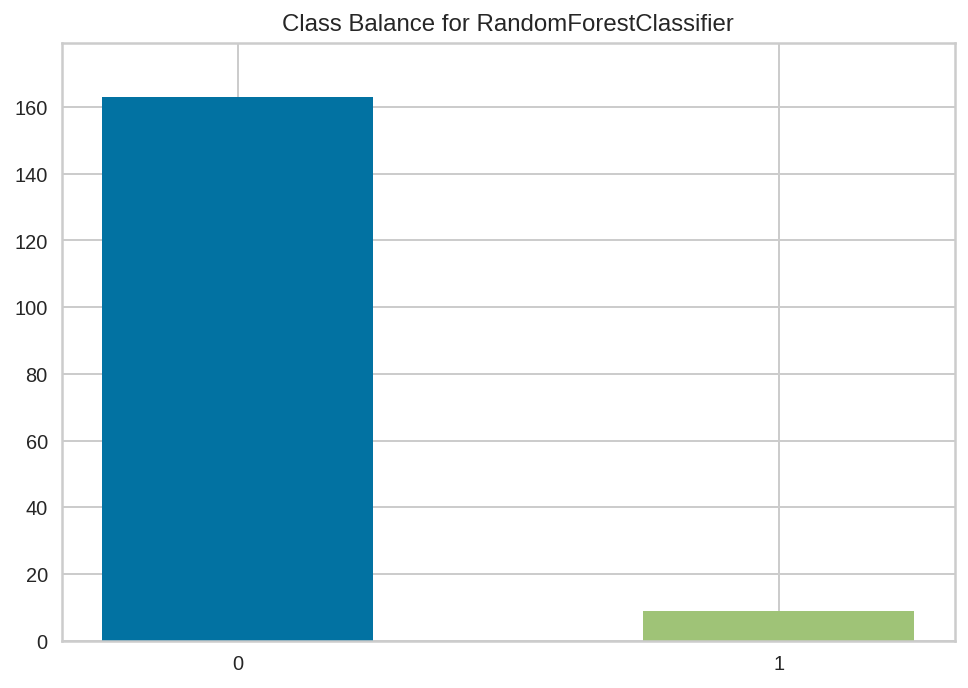

In [96]:
from yellowbrick.classifier import ClassificationReport, ROCAUC, ClassBalance, ConfusionMatrix

visualizer = ClassBalance(rf)

visualizer.fit(X_sam_rfe,y_sam)  # Fit the training data to the visualizer
visualizer.score(X_test_rfe, y_test)  # Evaluate the model on the test data
visualizer.poof()

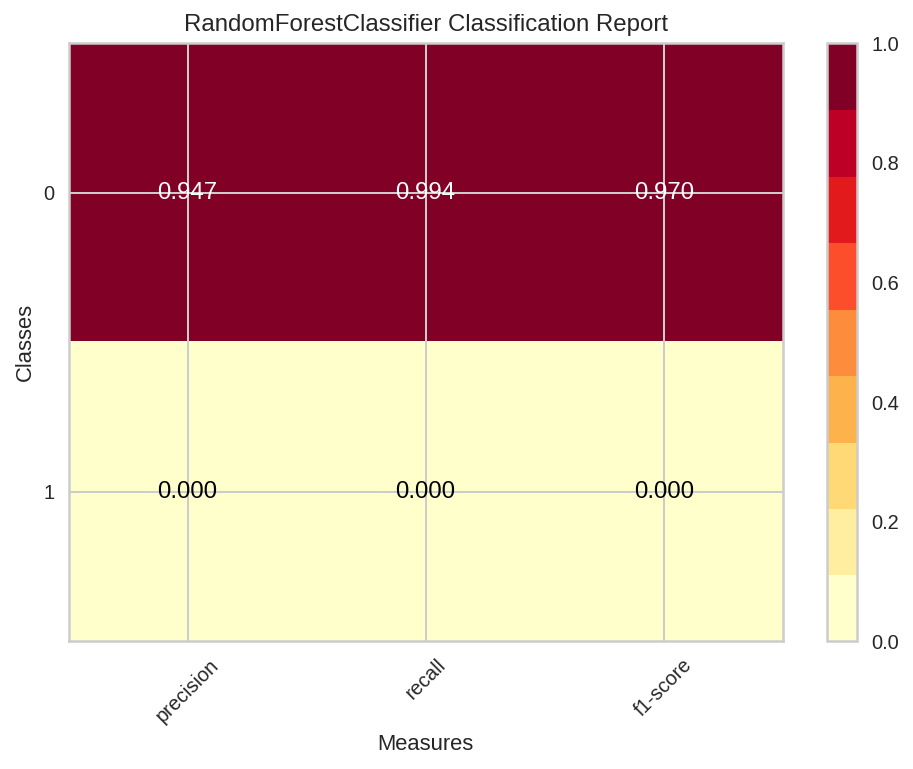

In [100]:
visualizer = ClassificationReport(rf)

visualizer.fit(X_sam_rfe, y_sam)  # Fit the training data to the visualizer
visualizer.score(X_test_rfe, y_test)  # Evaluate the model on the test data
visualizer.poof()

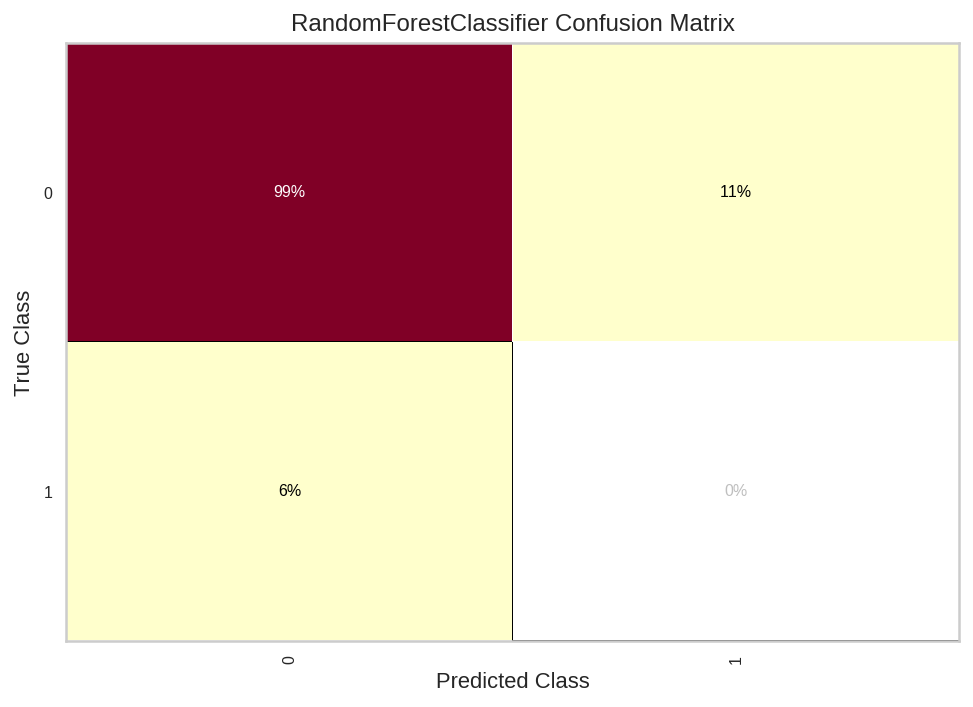

In [173]:
cm = ConfusionMatrix(rf)
cm.fit(X_sam_rfe, y_sam)
cm.score(X_test_rfe, y_test)

cm.poof()

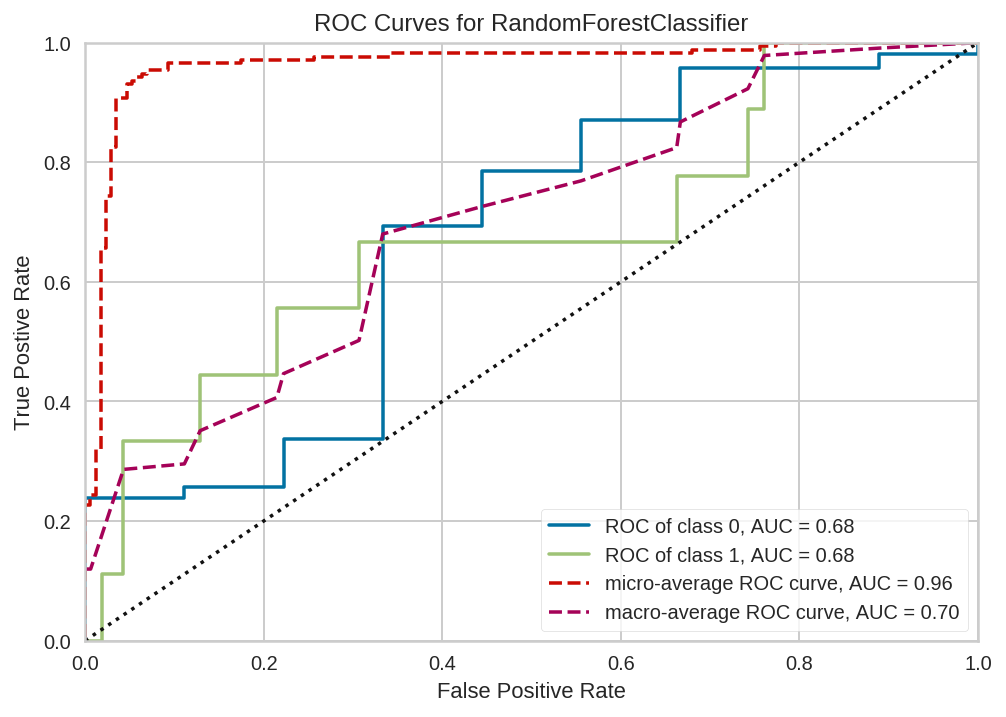

In [110]:
visualizer = ROCAUC(rf)

visualizer.fit(X_sam_rfe, y_sam)  # Fit the training data to the visualizer
visualizer.score(X_test_rfe, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

## No oversampling done

/home/ljiahest/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


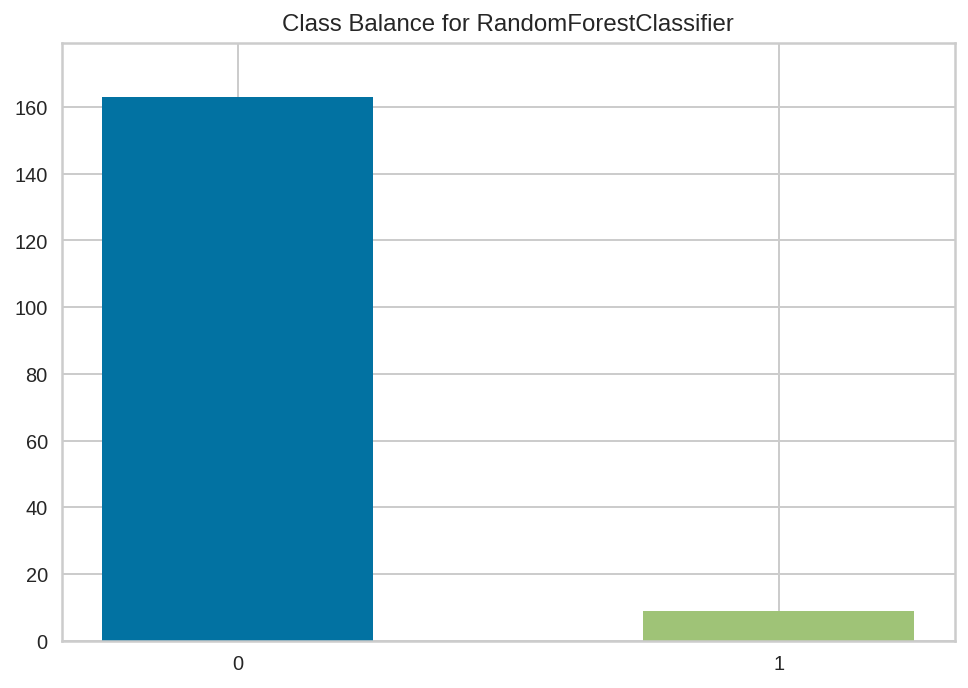

In [98]:
visualizer = ClassBalance(rf)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()

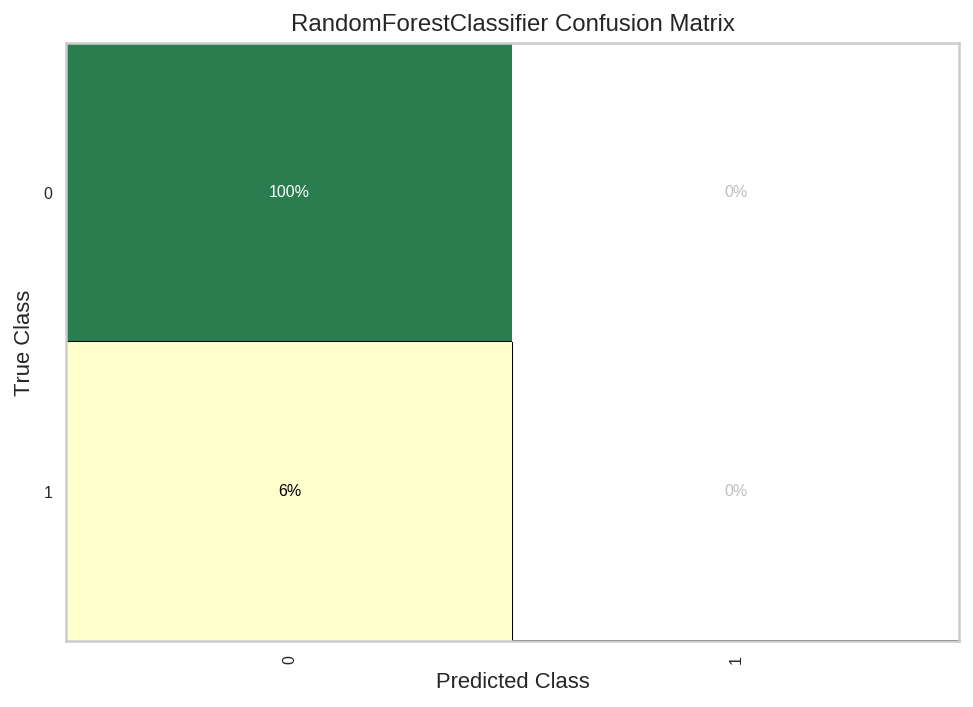

In [107]:
cm = ConfusionMatrix(rf)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

cm.poof()

## Cost Sensitive Modelling

In [111]:
import xgboost as xgb

In [163]:
dtrain = xgb.DMatrix(X_train, label = y_train, weight = weights)
dtest = xgb.DMatrix(X_test)

ratio = float (np.sum(y_test == 0)) / np.sum(y_test == 1)
params = {'objective': 'binary:logistic', 'max-depth':5, 'eta': 0.1, \
          'scale_pos_weight': ratio, 'gamma': 0.11}

clf = xgb.train(params, dtrain)
y_pred_proba = clf.predict(dtest) > 0.5
print (confusion_matrix(y_test, y_pred_proba))

[[ 51 112]
 [  0   9]]


In [171]:
from sklearn.metrics import classification_report
print (classification_report(y_test, y_pred_proba))

             precision    recall  f1-score   support

          0       1.00      0.31      0.48       163
          1       0.07      1.00      0.14         9

avg / total       0.95      0.35      0.46       172



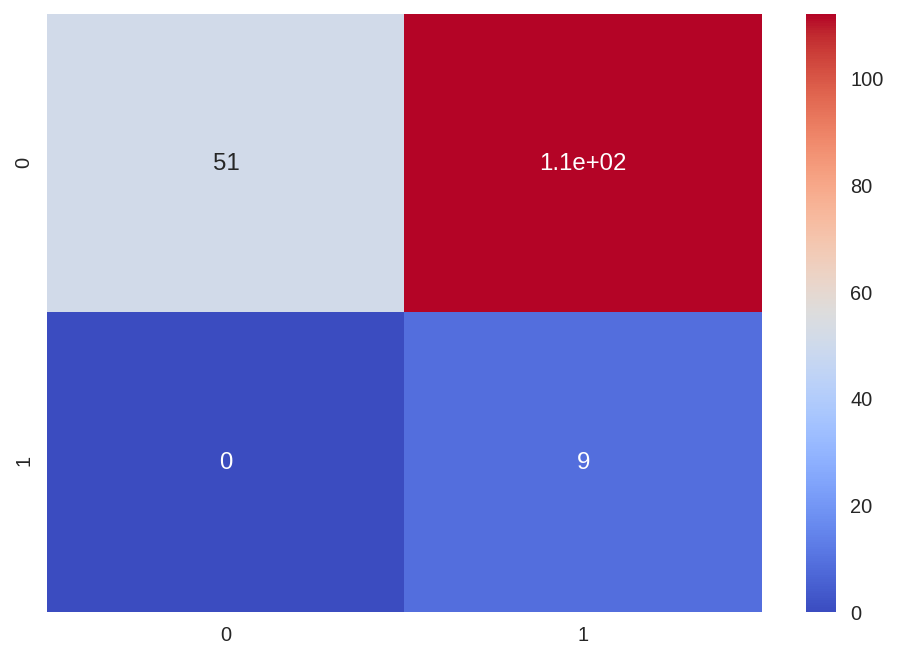

In [168]:
sns.heatmap(confusion_matrix(y_test, y_pred_proba), annot= True, cmap = 'coolwarm')